#### In this Notebook I explore the application of convolutional neural networks and computer vision to classify ct scans as tumorous or note. Note, the way in which the files are unzipped requires google colab to run. But, the code can be ran as long as the file paths are changed

In [0]:
#load packages
import sys
import time
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import os
import zipfile
import pandas as pd

from skimage.transform import resize
from sklearn.model_selection import train_test_split

from tensorflow.python.keras.utils import np_utils
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.python.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D 
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.applications  import VGG19, ResNet50, InceptionV3

In [2]:
#unzip contents
!unzip brain_tumor_dataset.zip  

Archive:  brain_tumor_dataset.zip
replace brain_tumor_dataset/no/1 no.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [0]:
#set base path as name of folder and categories as the subfolders that are used as training data
base_path = 'brain_tumor_dataset'
category = ['yes','no']

#iniate empty list and and append path of each file to list. This list is refered to in later code index (f.e.filenames[1])
filenames =[]
for prediction in category:
  image_folder = os.path.join(base_path, prediction) 
  file_names = os.listdir(image_folder)
  full_path = [os.path.join(image_folder,file_name) for file_name in file_names]
  filenames.append(full_path)

In [4]:
#the load image function takes an image and resizes with a min/max normalization 
from keras.preprocessing import image
import numpy as np
from PIL import Image

def load_image(img_path):
        img = Image.open(img_path).convert("RGB").resize((224,224)) # import image, make sure it's RGB and resize to height and width you want.
        img = (np.float32(img)-np.float32(img).min())/(np.float32(img).max()-np.float32(img).min()) # min max transformation
        img=img.reshape((224,224,3)) # Create final shape as array with correct dimensions for Keras
        return img

#apply min/max normalized "load_image" function to both slices of list
preprocessed_image_data=list(map(load_image, filenames[0]+filenames[1])) 

X= np.array(preprocessed_image_data)


Using TensorFlow backend.


In [0]:
#add labels to each image
from itertools import repeat
from PIL import Image
yes=list(repeat("yes", 155)) #there are 155 "yes" images in the training data
no=list(repeat("no", 98)) #there are 98 "no" images in the training data
y_labels = yes+no 
y=pd.get_dummies(y_labels) #create target variable for machine learning

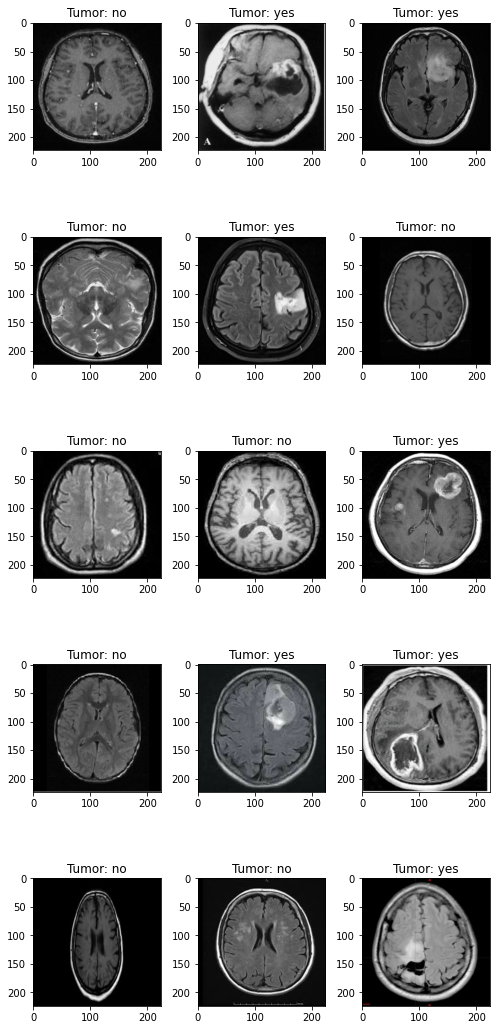

In [6]:
#print images first by setting size of visual
fig,ax=plt.subplots(5,3)
fig.set_size_inches(7,15)
#print random images in dataset
for i in range(5):
  for j in range (3):
    t=np.random.randint(0,len(y_labels))
    ax[i,j].imshow(X[t])
    ax[i,j].set_title('Tumor: '+y_labels[t])


plt.tight_layout()

In [0]:
#set training and test data
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20,random_state=42)

### Squeeze/Fire Net

#### A squeeze net convolutional neural network. Squeeze nets are the not the most precise CNN's, but offer superior accuracy with low processor power.

<img src="https://florianbordes.files.wordpress.com/2016/04/diagramme2_fire.png" width="600" height="600" />

In [0]:
with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  def fire(x, squeeze, expand):
    y  = tf.keras.layers.Conv2D(filters=squeeze, kernel_size=1, activation='relu', padding='same')(x)
    y = tf.keras.layers.BatchNormalization()(y)
    y1 = tf.keras.layers.Conv2D(filters=expand//2, kernel_size=1, activation='relu', padding='same')(y)
    y1 = tf.keras.layers.BatchNormalization()(y1)
    y3 = tf.keras.layers.Conv2D(filters=expand//2, kernel_size=3, activation='relu', padding='same')(y)
    y3 = tf.keras.layers.BatchNormalization()(y3)
    return tf.keras.layers.concatenate([y1, y3])

  def fire_module(squeeze, expand):
    return lambda x: fire(x, squeeze, expand)

  x = tf.keras.layers.Input(shape=[224,224, 3]) # input is 192x192 pixels RGB

  y = tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same',  activation='relu')(x)
  y = tf.keras.layers.BatchNormalization()(y)
  y = fire_module(24, 48)(y)
  y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
  y = fire_module(48, 96)(y)
  y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
  y = fire_module(64, 128)(y)
  y = tf.keras.layers.GlobalAveragePooling2D()(y)
  y = tf.keras.layers.Dense(2, activation='softmax')(y)
  model = tf.keras.Model(x, y)

  model.compile(
    optimizer='adam',
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc']) 

  model.fit(X_train, y_train, 
                    epochs = 5, verbose=0,validation_data=(X_test,y_test))

In [0]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import pandas as pd
from math import sqrt


#model_eval_metrics is used to print out the ratings of the best neural network weight results
def model_eval_metrics(y_true, y_pred,classification="TRUE"):
     if classification=="TRUE":
        accuracy_eval = accuracy_score(y_true, y_pred)
        f1_score_eval = f1_score(y_true, y_pred,average="macro",zero_division=0)
        precision_eval = precision_score(y_true, y_pred,average="macro",zero_division=0)
        recall_eval = recall_score(y_true, y_pred,average="macro",zero_division=0)
        mse_eval = 0
        rmse_eval = 0
        mae_eval = 0
        r2_eval = 0
        metricdata = {'accuracy': [accuracy_eval], 'f1_score': [f1_score_eval], 'precision': [precision_eval], 'recall': [recall_eval], 'mse': [mse_eval], 'rmse': [rmse_eval], 'mae': [mae_eval], 'r2': [r2_eval]}
        finalmetricdata = pd.DataFrame.from_dict(metricdata)
     else:
        accuracy_eval = 0
        f1_score_eval = 0
        precision_eval = 0
        recall_eval = 0
        mse_eval = mean_squared_error(y_true, y_pred)
        rmse_eval = sqrt(mean_squared_error(y_true, y_pred))
        mae_eval = mean_absolute_error(y_true, y_pred)
        r2_eval = r2_score(y_true, y_pred)
        metricdata = {'accuracy': [accuracy_eval], 'f1_score': [f1_score_eval], 'precision': [precision_eval], 'recall': [recall_eval], 'mse': [mse_eval], 'rmse': [rmse_eval], 'mae': [mae_eval], 'r2': [r2_eval]}
        finalmetricdata = pd.DataFrame.from_dict(metricdata)
     return finalmetricdata

In [0]:
#First, you need a predict classes function frok keras github
def predict_classes(x):
  proba=x
  if proba.shape[-1] > 1:
      return proba.argmax(axis=-1)
  else:
      return (proba > 0.5).astype("int32")

In [17]:
#predict labels
print(predict_classes(model.predict(X_test)))

prediction_index=predict_classes(model.predict(X_test))

labels=pd.get_dummies(y_train).columns

predicted_labels=list(map(lambda x: labels[x], prediction_index))
print(predicted_labels)

y_test_labels=y_test.idxmax(axis=1)

model_eval_metrics( y_test_labels,predicted_labels,classification="TRUE")

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
['yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes']


,accuracy,f1_score,precision,recall,mse,rmse,mae,r2
0,0.529412,0.346154,0.264706,0.5,0,0,0,0


### *the model with the squeezenet was not that strong, potentially because there were too many layers*

### Deep Convulutional Neural Network




#### A deep CNN is great a picking up patterns as it convolves over thee data to create patterns in the data and then pools the results to do so again.

In [0]:
with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model = tf.keras.Sequential([
      # input: images of size 192x192x3 pixels (the three stands for RGB channels)    
      tf.keras.layers.Conv2D(kernel_size=3, filters=64, padding='same', activation='relu', input_shape=[224, 224, 3]),
      tf.keras.layers.Conv2D(kernel_size=1, filters=64, padding='same', activation='relu'),
      tf.keras.layers.MaxPooling2D(pool_size=2),
      tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
      tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
      tf.keras.layers.MaxPooling2D(pool_size=2),
      tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
      tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
      tf.keras.layers.MaxPooling2D(pool_size=2),
      tf.keras.layers.Conv2D(kernel_size=3, filters=16, padding='same', activation='relu'),
      tf.keras.layers.Conv2D(kernel_size=1, filters=8, padding='same', activation='relu'),
      tf.keras.layers.Flatten(),
      # classifying into 2 categories
      tf.keras.layers.Dense(2, activation='softmax') ])
   
  model.compile(
  optimizer="adam", 
  loss= 'categorical_crossentropy',
  metrics=['accuracy'])
    
    # Fitting the CNN to the Training set
  model.fit(X_train, y_train, 
                      epochs = 10, verbose=0,validation_data=(X_test,y_test)) 

In [19]:
print(predict_classes(model.predict(X_test)))

prediction_index=predict_classes(model.predict(X_test))

labels=pd.get_dummies(y_train).columns

predicted_labels=list(map(lambda x: labels[x], prediction_index))
print(predicted_labels)

y_test_labels=y_test.idxmax(axis=1)

modelevalobject = model_eval_metrics( y_test_labels,predicted_labels,classification="TRUE")
modelevalobject

[1 1 0 0 1 0 0 0 1 1 0 0 1 0 1 1 1 1 1 1 1 0 1 1 1 1 0 0 1 0 1 1 1 1 1 1 1
 1 1 1 1 0 1 0 1 1 1 1 1 0 1]
['yes', 'yes', 'no', 'no', 'yes', 'no', 'no', 'no', 'yes', 'yes', 'no', 'no', 'yes', 'no', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'no', 'yes', 'yes', 'yes', 'yes', 'no', 'no', 'yes', 'no', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'no', 'yes', 'no', 'yes', 'yes', 'yes', 'yes', 'yes', 'no', 'yes']


,accuracy,f1_score,precision,recall,mse,rmse,mae,r2
0,0.745098,0.730159,0.780556,0.733796,0,0,0,0


### The Deep CNN is much better at prediciting on the test data.

### Convulutiona Neural Network - Trasnference

#### Transference models are sort of antagonsitic in nature. By freezing weights of the model and refeeding it back into the model later to prevent over tuning

In [20]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras import backend as K

IMG_SHAPE = (224, 224, 3)

base_model = VGG16(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
base_model.trainable = False

model = Sequential([
  base_model,
   GlobalAveragePooling2D(),
   Dense(2,activation="softmax")
])

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model.compile(
    optimizer='adam',
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc']) 

  model.fit(X_train, y_train,
          epochs = 5, verbose=0,validation_data=(X_test,y_test))

58892288/58889256 [==============================] - 1s 0us/step


In [21]:
prediction_index=predict_classes(model.predict(X_test))

labels=pd.get_dummies(y_train).columns

predicted_labels=list(map(lambda x: labels[x], prediction_index))

y_test_labels=y_test.idxmax(axis=1) #extract labels from one hot encoded y_test object

model_eval_metrics( y_test_labels,predicted_labels,classification="TRUE")

,accuracy,f1_score,precision,recall,mse,rmse,mae,r2
0,0.529412,0.346154,0.264706,0.5,0,0,0,0


### Final deep CNN model after some inital runs

In [0]:
from keras import optimizers
import keras
import multiprocessing as mp
mp.set_start_method('spawn', force=True)
with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model = tf.keras.Sequential([
      tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu', input_shape=[224, 224, 3]),
      tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
      tf.keras.layers.MaxPooling2D(pool_size=2),
      tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
      tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
      tf.keras.layers.MaxPooling2D(pool_size=2),
      tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
      tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
      tf.keras.layers.MaxPooling2D(pool_size=2),
      tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
      tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
      tf.keras.layers.MaxPooling2D(pool_size=2),
      tf.keras.layers.Conv2D(kernel_size=3, filters=16, padding='same', activation='relu'),
      tf.keras.layers.Conv2D(kernel_size=1, filters=8, padding='same', activation='relu'),
      tf.keras.layers.Flatten(),
      # classifying into 2 categories
      tf.keras.layers.Dense(2, activation='softmax') ])
  adam = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,name='Adam')


  model.compile(
  optimizer=adam,
  loss= 'categorical_crossentropy',
  metrics=['accuracy'])


  model.fit(X_train, y_train, 
                      epochs = 10, verbose=0,validation_data=(X_test,y_test))

In [15]:
prediction_index=predict_classes(model.predict(X_test))

#Now lets run some code to get keras to return the label rather than the index...

# get labels from one hot encoded y_train data
labels=pd.get_dummies(y_train).columns

# Iterate through all predicted indices using map method

predicted_labels=list(map(lambda x: labels[x], prediction_index))
print(predicted_labels)

y_test_labels=y_test.idxmax(axis=1)

model_eval_metrics( y_test_labels,predicted_labels,classification="TRUE")

['yes', 'yes', 'no', 'no', 'yes', 'no', 'no', 'no', 'yes', 'yes', 'no', 'no', 'no', 'no', 'yes', 'no', 'yes', 'yes', 'yes', 'yes', 'yes', 'no', 'yes', 'yes', 'yes', 'yes', 'no', 'no', 'yes', 'no', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'no', 'no', 'no', 'yes', 'yes', 'yes', 'yes', 'yes', 'no', 'yes']


,accuracy,f1_score,precision,recall,mse,rmse,mae,r2
0,0.764706,0.757143,0.780303,0.756944,0,0,0,0


### 76% not bad!